In [3]:
!pip install upsetplot

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24863 sha256=b65c9db0665c0f6984f32543b4220f8df4a5b3d066ee15f93895f7bf6bf314bc
  Stored in directory: /root/.cache/pip/wheels/7b/ce/88/1d0bce5b2680165c29c3e68416325e79674d5a9f422d037996
Successfully built upsetplot


In [18]:
!pip install numpy pandas matplotlib scikit-learn

In [ ]:
camembert_file  = "sample_data/tous_entites_nommes_Camembert.json"
stanza_file = "sample_data/tous_entites_nommes_Stanza.json"
spacy_lg_file = "sample_data/tous_entites_nommes_Spacy_lg.json"
spacy_sm_file = "sample_data/tous_entites_nommes_Spacy_sm.json"
flaubert_file = "sample_data/tous_entites_nommes_Flaubert_0428.json"

Lecture de Camembert ...
Lecture de Stanza ...
Lecture de Spacy_lg ...
Lecture de Spacy_sm ...
Lecture de Flaubert ...

Mod√®les inclus : ['Camembert', 'Stanza', 'Spacy_lg', 'Spacy_sm', 'Flaubert']


/usr/local/lib/python3.11/dist-packages/upsetplot/data.py:385: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.11/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

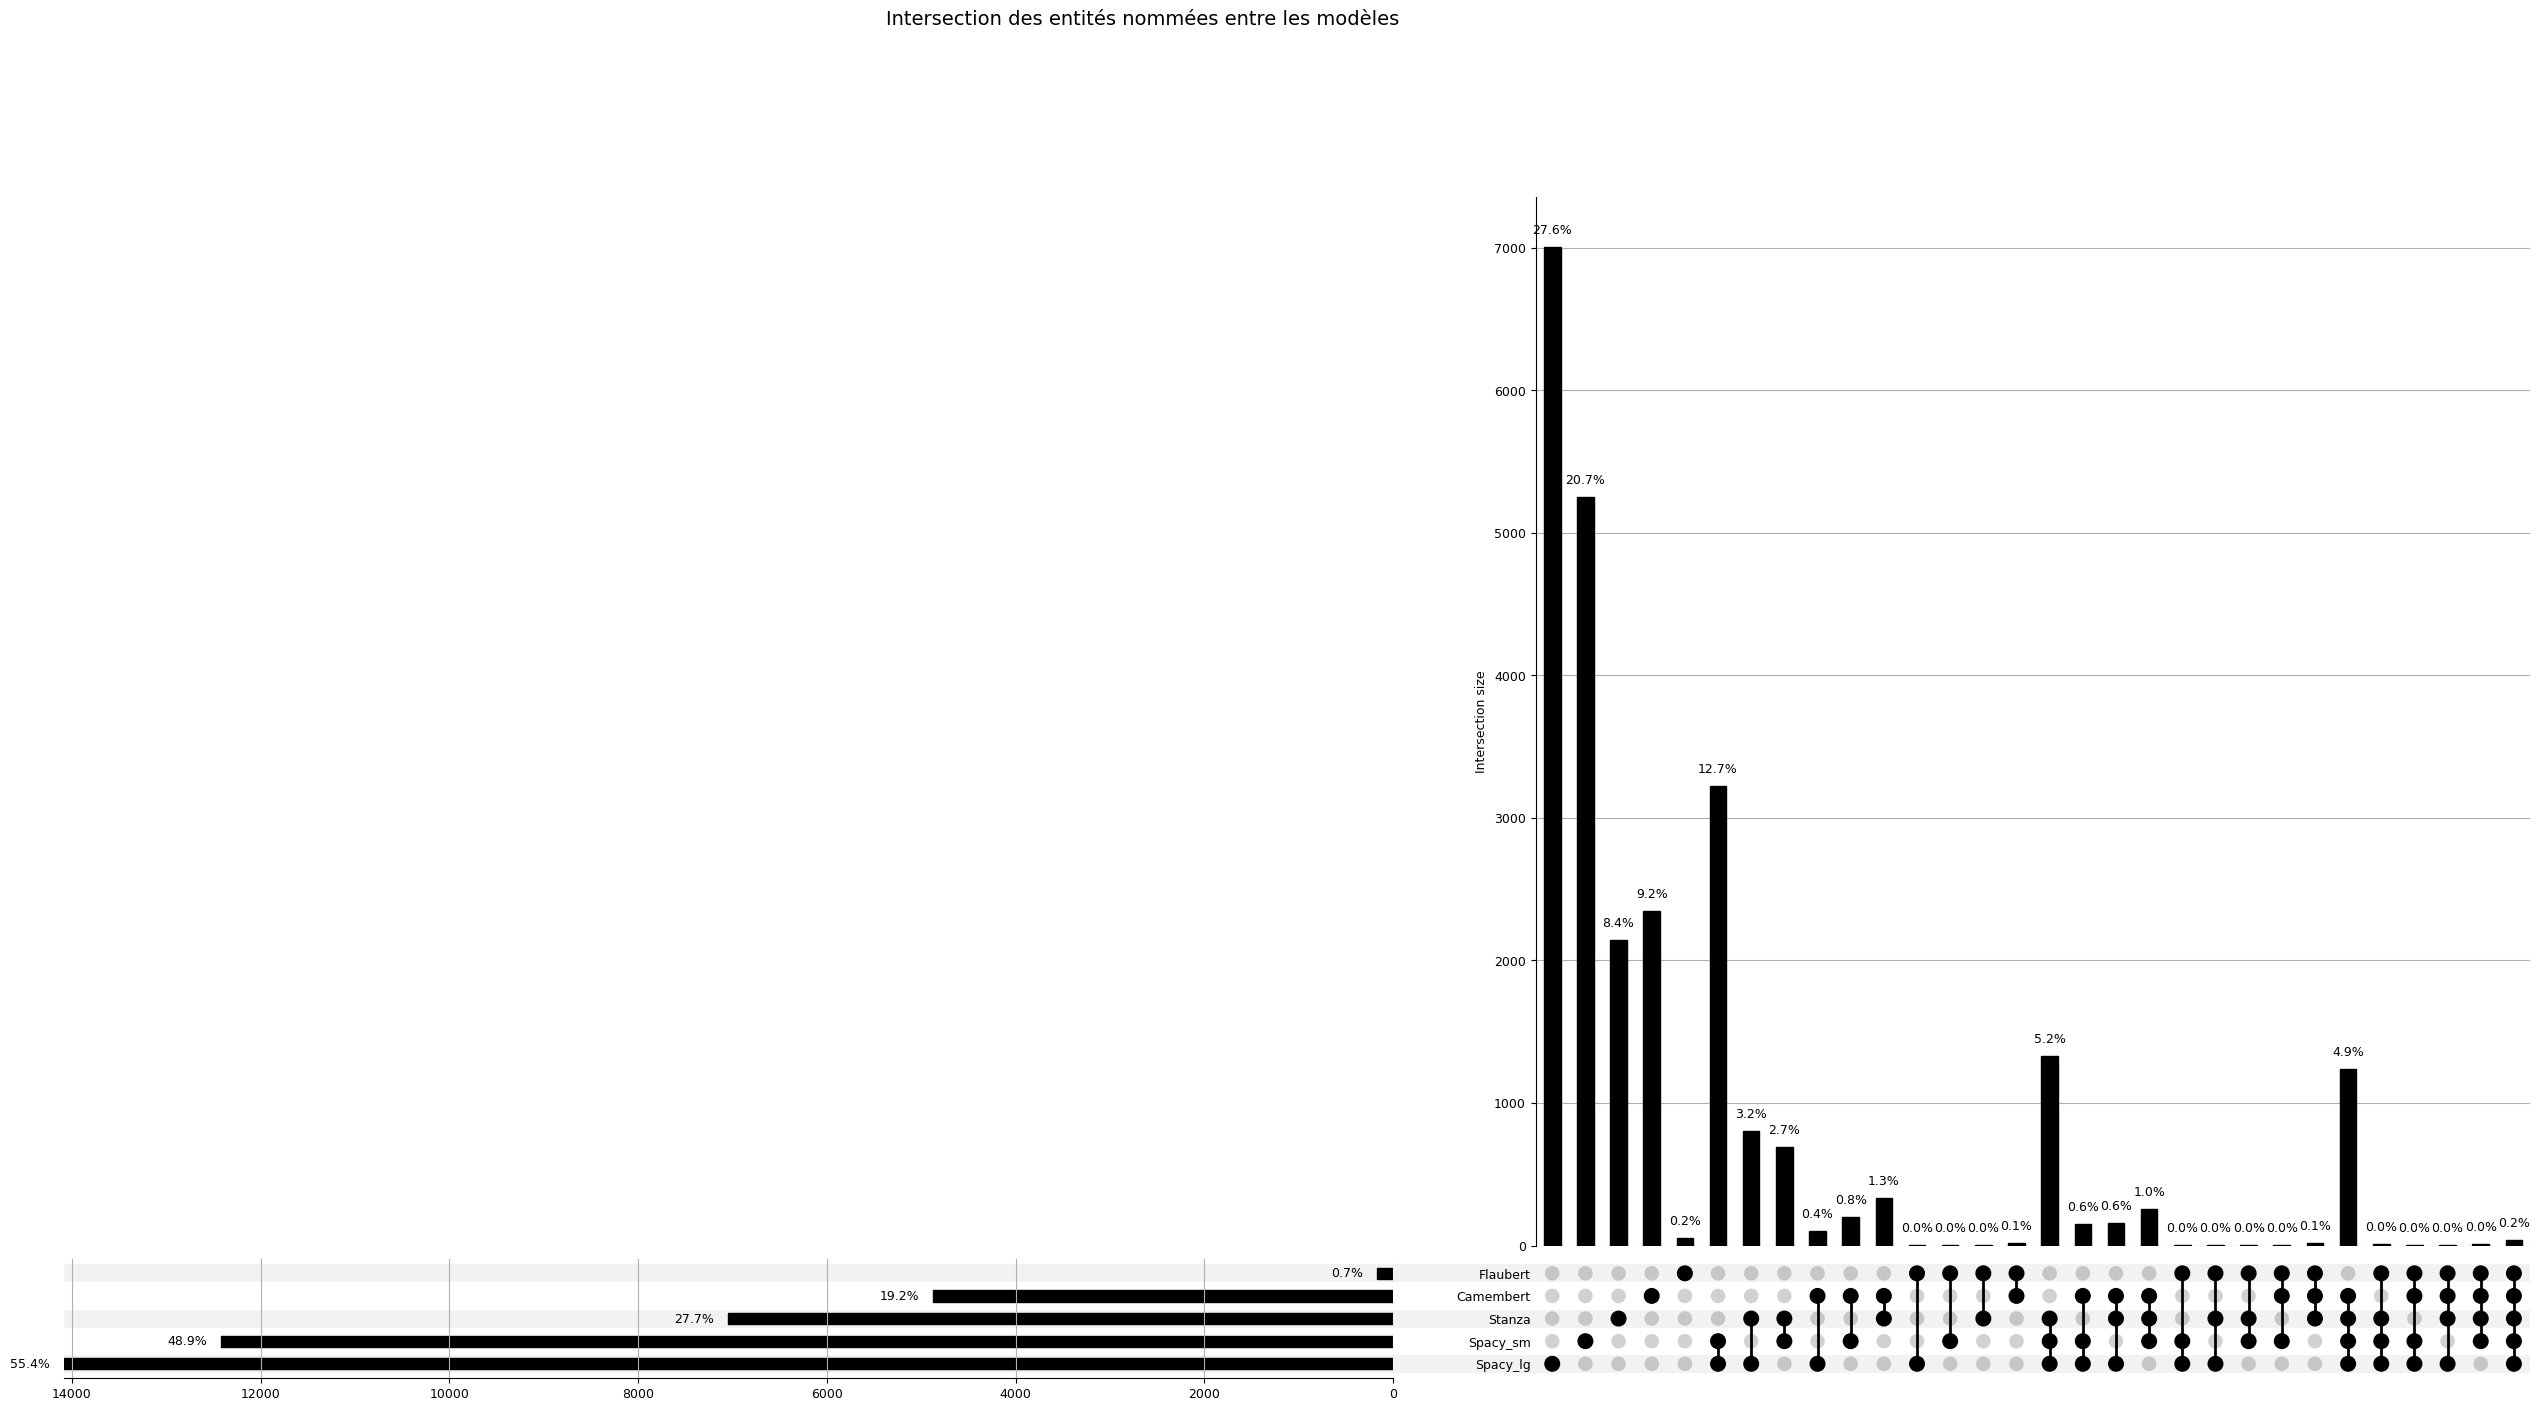

In [36]:
import json
import re
from matplotlib import pyplot as plt
from upsetplot import from_contents, UpSet

# === Fonction g√©n√©rale pour lire automatiquement les entit√©s nomm√©es, quel que soit le format JSON ===
def lire_entites_unifiees(chemin):
    import json, re

    with open(chemin, encoding='utf-8') as f:
        contenu = f.read()

    entites_extraites = []

    try:
        data = json.loads(contenu)

        if "entites" in data:  # ‚úÖ Format Camembert / Stanza
            entites_extraites = [e["mot"] for e in data["entites"] if "mot" in e]

        elif isinstance(data, dict):  # ‚úÖ Format SpaCy / Flaubert (documents multiples)
            for doc_data in data.values():
                # ‚û§ G√©rer les deux formats : "entit√©s" ou "entit√©s nomm√©es"
                entite_liste = (
                    doc_data.get("entit√©s nomm√©es")
                    or doc_data.get("entit√©s")
                    or []
                )
                entites_extraites.extend(
                    [e.get("texte") for e in entite_liste if "texte" in e]
                )

    except json.JSONDecodeError:
        # Cas o√π plusieurs objets JSON sont concat√©n√©s (format brut)
        blocs = re.findall(r'\{.*?\}', contenu, re.DOTALL)
        for bloc in blocs:
            try:
                obj = json.loads(bloc)
                if "entites" in obj:
                    entites_extraites.extend([e["mot"] for e in obj["entites"] if "mot" in e])
            except Exception:
                continue

    return set(entites_extraites)


# === Dictionnaire des fichiers : associer chaque mod√®le √† son fichier JSON ===
file_model_map = {
    "Camembert": "sample_data/tous_entites_nommes_Camembert.json",
    "Stanza": "sample_data/tous_entites_nommes_Stanza.json",
    "Spacy_lg": "sample_data/tous_entites_nommes_Spacy_lg.json",
    "Spacy_sm": "sample_data/tous_entites_nommes_Spacy_sm.json",
    "Flaubert": "sample_data/tous_entites_nommes_Flaubert_0428.json"
}

# === Lecture des entit√©s nomm√©es pour tous les mod√®les ===
dico_fusionne = {}

for modele, chemin in file_model_map.items():
    print(f"Lecture de {modele} ...")
    dico_fusionne[modele] = lire_entites_unifiees(chemin)

print("\nMod√®les inclus :", list(dico_fusionne.keys()))

# === Visualisation UpSetPlot ===

# Cr√©ation de la structure de donn√©es √† partir du dictionnaire
test = from_contents(dico_fusionne)

# Configuration du graphique UpSet
upset = UpSet(
    test,
    orientation='horizontal',             # Affichage horizontal
    sort_by='degree',                     # Trier par nombre de mod√®les
    show_percentages=True,                # Afficher les pourcentages
    totals_plot_elements=40,              # Nombre de mod√®les affich√©s dans le total
    intersection_plot_elements=40,        # Nombre de combinaisons d‚Äôintersection affich√©es
    element_size=30                       # Taille verticale d‚Äôun √©l√©ment (ligne)
)

# Taille de la figure (adapt√©e √† 5 mod√®les et nombreuses intersections)
fig = plt.figure(figsize=(30, 15))
plt.subplots_adjust(
    left=0.15,    # Marge gauche pour les noms de mod√®les
    right=0.95,
    top=0.88,
    bottom=0.25,
    wspace=0.35,  # Espacement horizontal entre les sous-graphes
    hspace=0.25   # Espacement vertical
)

# G√©n√©rer le graphique
upset.plot(fig=fig)

# R√©duction de la taille de toutes les polices de caract√®res
for text in fig.findobj(plt.Text):
    text.set_fontsize(9)

# Titre g√©n√©ral
plt.suptitle("Intersection des entit√©s nomm√©es entre les mod√®les", fontsize=14)

# Sauvegarde et affichage
plt.savefig("upsetplot_all_models_adjusted.png", dpi=300)
plt.show()








Lecture des entit√©s nomm√©es extraites par chaque mod√®le...
üîß Construction de la matrice binaire mod√®le √ó entit√©...
Pr√©paration des param√®tres pour le diagramme de Venn...
G√©n√©ration du diagramme de Venn...


/content/venn.py:222: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = minimize(lambda p: lossFunction(p, radii, disjointOverlaps), centers, method='Nelder-Mead', options={'maxiter': 100, 'disp': True})


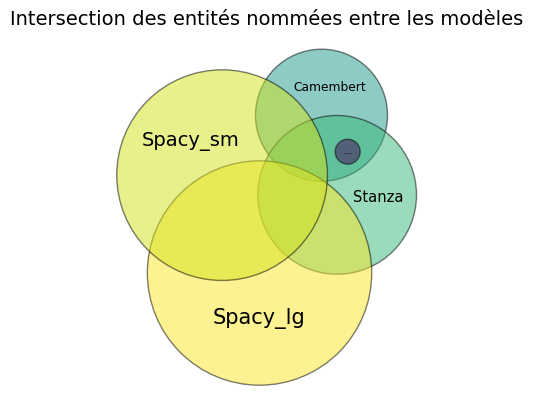

Diagramme sauvegard√© sous le nom : venn_ner_models.png


In [38]:
import json
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from venn import df2areas, venn  #Import du module personnalis√© pour Venn

# === Fonction pour lire automatiquement les entit√©s nomm√©es √† partir d‚Äôun fichier JSON ===
def lire_entites_unifiees(chemin):
    import json, re

    with open(chemin, encoding='utf-8') as f:
        contenu = f.read()

    entites_extraites = []

    try:
        data = json.loads(contenu)

        if "entites" in data:  # Format Camembert / Stanza
            entites_extraites = [e["mot"] for e in data["entites"] if "mot" in e]

        elif isinstance(data, dict):  # Format SpaCy / Flaubert (plusieurs documents)
            for doc_data in data.values():
                # ‚û§ Gestion des deux cl√©s possibles : "entit√©s" ou "entit√©s nomm√©es"
                entite_liste = (
                    doc_data.get("entit√©s nomm√©es")
                    or doc_data.get("entit√©s")
                    or []
                )
                entites_extraites.extend(
                    [e.get("texte") for e in entite_liste if "texte" in e]
                )

    except json.JSONDecodeError:
        # Cas de fichiers JSON concat√©n√©s (non standard)
        blocs = re.findall(r'\{.*?\}', contenu, re.DOTALL)
        for bloc in blocs:
            try:
                obj = json.loads(bloc)
                if "entites" in obj:
                    entites_extraites.extend([e["mot"] for e in obj["entites"] if "mot" in e])
            except Exception:
                continue

    return set(entites_extraites)


# === Dictionnaire associant les mod√®les aux fichiers JSON correspondants ===
file_model_map = {
    "Camembert": "sample_data/tous_entites_nommes_Camembert.json",
    "Stanza": "sample_data/tous_entites_nommes_Stanza.json",
    "Spacy_lg": "sample_data/tous_entites_nommes_Spacy_lg.json",
    "Spacy_sm": "sample_data/tous_entites_nommes_Spacy_sm.json",
    "Flaubert": "sample_data/tous_entites_nommes_Flaubert_0428.json"
}


# === Programme principal ===
def main():
    print("Lecture des entit√©s nomm√©es extraites par chaque mod√®le...")
    model_entities = {name: lire_entites_unifiees(path) for name, path in file_model_map.items()}

    all_entities = set.union(*model_entities.values())

    print("üîß Construction de la matrice binaire mod√®le √ó entit√©...")
    data = defaultdict(dict)
    for entity in all_entities:
        for model, ents in model_entities.items():
            data[entity][model] = int(entity in ents)

    df = pd.DataFrame.from_dict(data, orient='index')

    print("Pr√©paration des param√®tres pour le diagramme de Venn...")
    labels, radii, actualOverlaps, disjointOverlaps = df2areas(df, fineTune=True)

    print("G√©n√©ration du diagramme de Venn...")
    fig, ax = venn(
        radii,
        actualOverlaps,
        disjointOverlaps,
        labels=labels,
        labelsize='auto',
        cmap=None,
        fineTune=True
    )
    plt.title("Intersection des entit√©s nomm√©es entre les mod√®les", fontsize=14)
    plt.savefig("venn_ner_models.png", dpi=300, transparent=True)
    plt.show()
    print("Diagramme sauvegard√© sous le nom : venn_ner_models.png")


if __name__ == "__main__":
    main()
